In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'conv1d'

clean = True

## Reading Flies data and splitting into Train/Val/Test

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sb
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import deepdish as dd
from wavhandler import *

### data collecting

In [ ]:
mebios = DatasetConfiguration(names=['Suzukii_RL'])
mebios.select_all(); 
mebios.read();
if clean:
    mebios.clean();
mebios.df.labels.value_counts()

In [ ]:
rodr_tr,rodr_ts = train_test_filenames2(dataset='Rodrigo',species='D. melanogaster', clean=clean, plot=True, test_dates=['20200310','20200311','20200312', '20200313', '20200314', '20200315','20200316'])

In [ ]:
rodsuz = DatasetConfiguration(names=['Rodrigo'])
rodsuz.select(name='Rodrigo', species=['D. suzukii'])
rodsuz.read()
if clean:
    rodsuz.clean()
rodsuz.df.labels.value_counts()    

In [ ]:
mebiosmel = DatasetConfiguration(names=['Melanogaster_RL'])
mebiosmel.select(name='Melanogaster_RL', species=['W'])
mebiosmel.read()
if clean:
    mebiosmel.clean()
mebiosmel.df.labels = mebiosmel.df.labels.apply(lambda x: x.replace("W", "D. melanogaster"))
mebiosmel.df.labels.value_counts()

Dataset - LG - exists: True
['20180925', '20180922', '20180923', '20180920', '20180921', '20180919', '20180924', '20180926']
5379 train filenames, 1745 test filenames


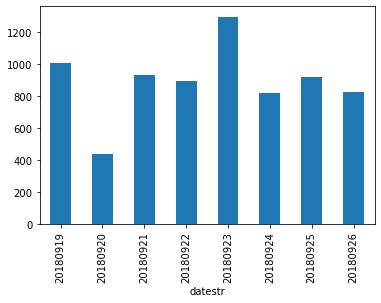

In [7]:
lg_tr, lg_ts = train_test_filenames2(dataset='LG',species='LG_zapr_26_09', clean=clean, plot=True, test_dates=['20180926', '20180925'])

## train

In [8]:
train_meb = mebios.df[mebios.df.labels.isin(['R'])]
train = pd.concat([train_meb, rodr_tr, lg_tr])
train.labels = train.labels.apply(lambda x: f'{x.replace("R", "D. suzukii")}')
train.labels.value_counts()

D. suzukii         11457
LG_zapr_26_09       5379
D. melanogaster     3912
Name: labels, dtype: int64

## test

In [9]:
test_meb = mebios.df[mebios.df.labels.isin(['L'])]
test_meb.labels = test_meb.labels.apply(lambda x: x.replace("L", "D. suzukii"))
test = pd.concat([test_meb, rodr_ts, rodsuz.df,lg_ts, mebiosmel.df])
test.labels.value_counts()

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


D. suzukii         17367
LG_zapr_26_09       1745
D. melanogaster     1443
Name: labels, dtype: int64

### data splitting

In [10]:
if splitting == 'random':
    tmp = pd.concat([train, test])
    X_train, X_test, y_train, y_test = train_test_split(tmp.fnames.tolist(), tmp.labels.tolist(), shuffle=True, random_state=42)
elif splitting == 'custom':
    X_train = train.fnames.tolist()
    X_test = test.fnames.tolist()
    y_train = train.labels.tolist()
    y_test = test.labels.tolist()
else:
    raise ValueError('Wrong splitting method')
    
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
D. suzukii         11457
LG_zapr_26_09       5379
D. melanogaster     3912
dtype: int64

test: 
D. suzukii         17367
LG_zapr_26_09       1745
D. melanogaster     1443
dtype: int64


In [11]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
pd.Series(y_test).value_counts()

1    17367
2     1745
0     1443
dtype: int64

### training

In [12]:
traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=f"Flies_{data_setting}_{model_setting}_{splitting}", monitor='val_accuracy')

In [13]:
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=3)
model = modelconf.config
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

############ INPUT SHAPE:(5000, 1)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, shuffle=True)

In [15]:
h = model.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                     preprocessing_train_stats=''),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                         preprocessing_train_stats=''),
                    validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list)

Epoch 1/100
487/487 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.8987
Epoch 00001: val_accuracy improved from -inf to 0.24908, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_conv1d_custom.h5
487/487 [==============================] - 90s 186ms/step - loss: 0.2642 - accuracy: 0.8987 - val_loss: 6.0700 - val_accuracy: 0.2491 - lr: 0.0010
Epoch 2/100
487/487 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9425
Epoch 00002: val_accuracy improved from 0.24908 to 0.85984, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_conv1d_custom.h5
487/487 [==============================] - 21s 44ms/step - loss: 0.1615 - accuracy: 0.9425 - val_loss: 0.3384 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 3/100
487/487 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9528
Epoch 00003: val_accuracy improved from 0.85984 to 0.92848, saving model to /home/kalfasyan/pro

In [16]:
pred = model.predict_generator(valid_generator(X_test, y_test,
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                  preprocessing_train_stats=''),
                              steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

Instructions for updating:
Please use Model.predict, which supports generators.


In [17]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(pred, axis=1))

0.9236051231214472

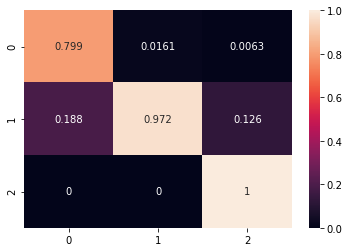

In [18]:
import seaborn as sns

cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred, axis=1))
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=1)

sns.heatmap(cm, annot=True, fmt='.3g')

#### 0=melanogaster, 1=suzukii, 2=zaprionus

In [19]:
print(get_labelencoder_mapping(le))
pd.Series(y_test).value_counts()

{'D. melanogaster': 0, 'D. suzukii': 1, 'LG_zapr_26_09': 2}


1    17367
2     1745
0     1443
dtype: int64

In [20]:
y_pred = np.argmax(pred, axis=1)

sub = pd.concat([pd.Series(y_test), pd.Series(X_test)], axis=1)
sub['preds'] = y_pred
sub.columns = ['labels','fnames','preds']
sub['datestr'] = get_wingbeat_dates(sub.fnames)[2]

In [21]:
sub.to_csv(f'{TEMP_DATADIR}/df_{model_setting}_{data_setting}_{splitting}.csv', index=False)

### Loading MosquitoNet and removing its last 2 layers

In [ ]:
merged = False

using_conv2d = False
if merged:
    # Merging the mosquito genuses together
    y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()

    # Defining model parameters
    modelname = f"FliesTL_{data_setting}_{model_setting}_{splitting}_merged{merged}"
    traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=modelname)
    d.target_classes = ['Aedes','Anopheles','Culex']
    traincf.target_names = np.unique(d.target_classes)
    traincf.targets = len(traincf.target_names)    
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=3).config
else:
    modelname = f"FliesTL_{data_setting}_{model_setting}_{splitting}_merged{merged}"
    traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=6).config

model.load_weights(TEMP_DATADIR+modelname+'.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# NOT LOADING MODELS
model.summary()

if data_setting in ['raw', 'rawflt','psd','psdflt', 'psd_dB','psd_dBflt']:
    # cut_mosquito_model is the model without its last dropout and softmax
    cut_mosquito_model = Model(model.inputs, model.layers[-3].output)
elif data_setting in ['stft','stftflt']:
    cut_mosquito_model = Model(model.inputs, model.layers[-2].output)

In [ ]:
input_shape=cut_mosquito_model.output_shape[1:]

### Creating a shallow model to put on top of Mosquito model
top_model = Sequential()
top_model.add(Flatten(input_shape=input_shape))
top_model.add(Dropout(0.5))
top_model.add(Dense(3, activation='softmax'))
top_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
Xf_xtracted_train = cut_mosquito_model.predict(valid_generator(X_train, 
                                                y_train, 
                                                batch_size=128, 
                                                setting=data_setting, 
                                                preprocessing_train_stats='',
                                                target_names=np.unique(y_test).tolist()),
                                            steps = int(math.ceil(float(len(X_train)) / float(128))))

Xf_xtracted_val = cut_mosquito_model.predict(valid_generator(X_val, 
                                                y_val, 
                                                batch_size=128, 
                                                preprocessing_train_stats='',
                                                setting=data_setting, 
                                                target_names=np.unique(y_test).tolist()),
                                            steps = int(math.ceil(float(len(X_val)) / float(128))))    

In [ ]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(3)}

### Training Shallow model for a few epochs
traincf_flies = TrainConfiguration(nb_classes=3, setting='rawflt', monitor='val_accuracy', 
                                   model_name=f'top_model_flies', batch_size=32, epochs=10)

In [ ]:
from tensorflow.keras.utils import to_categorical

top_model.fit(Xf_xtracted_train, to_categorical(y_train, num_classes=3), 
              validation_data=(Xf_xtracted_val,to_categorical(y_val, num_classes=3)),
              batch_size=traincf_flies.batch_size, 
              epochs=traincf_flies.epochs, 
              callbacks=traincf_flies.callbacks_list,
             class_weight=class_weights,
             verbose=1);

In [ ]:
### Adding shallow model on top of the cut Mosquito model
inputA = Input(cut_mosquito_model.input_shape[1:])
outputA = cut_mosquito_model(inputA)
outputB = top_model(outputA)
modelC = Model(inputA, outputB)
modelC.compile(loss='categorical_crossentropy',
              optimizer='adam',#optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])
### Training MosquitoNet+Shallow
traincf_flies = TrainConfiguration(nb_classes=3, setting=data_setting, monitor='val_accuracy', model_name=f'whole_model_flies', batch_size=32)
h = modelC.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf_flies.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    preprocessing_train_stats='',
                                    setting=traincf_flies.setting),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf_flies.batch_size))),
                    epochs = traincf_flies.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf_flies.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        preprocessing_train_stats='',
                                                        setting=traincf_flies.setting),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf_flies.batch_size))),
                    callbacks=traincf_flies.callbacks_list, 
                    class_weight=class_weights, 
                    verbose=1);

yf_pred = modelC.predict(valid_generator(X_test, 
                        y_test, 
                        batch_size=128, 
                        setting=data_setting, 
                         preprocessing_train_stats='',
                        target_names=np.unique(y_test).tolist()),
                    steps = int(math.ceil(float(len(X_test)) / float(128))))

In [26]:
balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(yf_pred, axis=1))

0.9469511247636517